In [1]:
%matplotlib inline


분류기(Classifier) 학습하기
============================

 

데이터는 어떻게 하나요?
------------------------


특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있다.


 CIFAR10 데이터셋을 사용한다.
 
 CIFAR10은
``'비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)','사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'``의 라벨로 이루어져 있다.

그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로 이루어져 있으며 ,RGB 이미지라 채널이 3이며 32픽셀X32픽셀로 이루어진 이미지들이다.


이미지 분류기 학습하기
----------------------------

다음과 같은 단계로 진행해보도록 하자:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)를 한다.
2. 합성곱 신경망(Convolution Neural Network)을 정의한다.
3. 손실 함수를 정의한다.
4. 학습용 데이터를 사용하여 신경망을 학습한다.
5. 시험용 데이터를 사용하여 신경망을 검사한다.

----------------
### 1. CIFAR10 데이터 셋을 불러오고 정규화하기


``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지이기 때문에
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환한다.

In [3]:
# transform은 이미지 데이터를 변형을 적용시키기 위한 함수
# torchvision의 데이터 출력은 0에서1의 범위이기 때문에 -1에서 1의 범위로 정규화된 텐서로 변환한다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 데이터를 받아온다. root는 데이터를 저장할 위치 train은 학습용인지 테스트용인지, download는 다운 받을 것인지,
# transform은 위에서 선언한 변형을 적용시킬것들을 넣어주면된다.
# ldataloader를 통해 trainset에 배치를 적용시키고 랜덤하게 섞어준다. num_workers는 멀티프로세스를 몇개로 하겠는지에 대한 인자이다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


학습용 이미지를 확인한다.


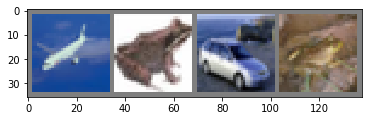

plane  frog   car  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기

 기본 CNN Network를 정의한다. 2개의 합성곱레이어와 3개의 완전연결 레이어로 이루어지도록 정의.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 손실 함수와 Optimizer 정의하기

교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 한다.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 신경망 학습하기

 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)를 진행한다.

- epoch : 총 데이터 셋을 몇 번 학습할 것인지에 대한 파라미터

In [7]:
for epoch in range(2):   # 데이터셋을 수차례 반복.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.158
[1,  4000] loss: 1.834
[1,  6000] loss: 1.679
[1,  8000] loss: 1.584
[1, 10000] loss: 1.525
[1, 12000] loss: 1.485
[2,  2000] loss: 1.422
[2,  4000] loss: 1.384
[2,  6000] loss: 1.367
[2,  8000] loss: 1.324
[2, 10000] loss: 1.304
[2, 12000] loss: 1.302
Finished Training


학습한 모델을 저장
- ``PATH``는 저장 위치/파일이름 모델을 저장할 때에는 .pth확장자를 사용해서 저장한다.
- ``torch.save``명령어를 통해 path에 지금 모델을 저장할 수 있다.

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. 시험용 데이터로 신경망 검사하기

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인한다.

만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣는다.


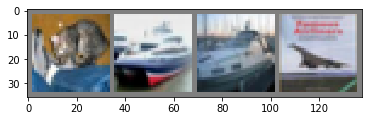

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
images[0]

tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

        [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
         [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
         [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
         ...,
         [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
         [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
         [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

        [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
         [-0.6000, -0.6863, -0.6471,  ..., -0

 위에서 저장했던 모델을 불러온다.

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

 어떻게 예측했는지 확인한다.

In [12]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타난다. 

어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것이다.


따라서, 가장 높은 값을 갖는 인덱스를 확인한다.

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


 샘플로 4개의 이미지의 예측을 확인했으니 전체 테스트 데이터 셋을 예측한다.

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


각 라벨별로 정확도를 알아본다.

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 67 %
Accuracy of  bird : 45 %
Accuracy of   cat : 14 %
Accuracy of  deer : 33 %
Accuracy of   dog : 65 %
Accuracy of  frog : 78 %
Accuracy of horse : 51 %
Accuracy of  ship : 70 %
Accuracy of truck : 68 %


GPU에서 학습하기
----------------

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력한다:

print(device)

cuda:0


net.to(device)와 inputs.labels = inputs.to(device)m,labels.to(device)를 통해 GPU에서 연산을 할 수 있다.

-------------------
위의 신경말을 좀 더 깊고 복잡하게 꾸며 정확도를 높여보자.

In [17]:
# %%%%%%INVISIBLE_CODE_BLOCK%%%%%%
del dataiter